# Model: ARIMA, Stock Token: CMG, Train/Test: 70/30
- Dataset: 1313 rows x 7 columns (01/03/2019 - 01/06/2024)
----
### Model evaluation (Test set)
- RMSE: 37150.39
- MAE: 37112.13
- MAPE: 4.93 %

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import joblib
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

## 1. Data preprocessing

In [2]:
stocks = ["FPT", "CMG", "ITD"]  # Stock token in dataset
ratios=[0.8,0.7,0.9]
targets = ["close"]  # The closing price is the target we want to predict
train_test_split = ["82", "73", "91"]  # Percent of for train, test

project_path = os.getcwd()
data_path = os.path.join(project_path, "data\\")
project_path_optimize = os.path.join(project_path, "optimize\\")
processing_output = os.path.join(project_path, "processing_output\\")

os.makedirs(processing_output, exist_ok=True)

T = 60  # ----> lookback
TF = 1  # ----> predict
NFeature = 1  # ----> feautures

data_set = {1: "train", 2: "test"}
stock_id = 1 # 0: FPT, 1: CMG, 2: ITD
n_split = 1 # 0: 82, 1: 73, 2: 91

In [3]:
def getData(index):
    df = pd.read_csv(f"../../Dataset/{stocks[index]}_stock.csv", index_col="time")

    return df[[targets[0]]]

In [4]:
df = getData(stock_id)
df.head()

,close
time,
2019-03-01,13480
2019-03-04,13970
2019-03-05,14460
2019-03-06,14060
2019-03-07,13830


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1313 entries, 2019-03-01 to 2024-05-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   close   1313 non-null   int64
dtypes: int64(1)
memory usage: 20.5+ KB


In [6]:
df.describe()

,close
count,1313.000000
mean,26832.390708
std,10097.555228
min,10880.000000
25%,17810.000000
50%,28380.000000
75%,34350.000000
max,63600.000000


In [7]:
df.isna().sum()

close    0
dtype: int64

Preprocess

In [8]:
def normalizationMinMax(df, set):
    """
  Params:
      * df -- DataFrame:        Dataframe need to be scaled
      * set -- int:  A string to recognize that dataset is train/test
  Returns:
      * scaler:     used for future inverse-transform
      * df_scaled:  df after normalization

  """
    scaler = MinMaxScaler()

    processes_folder = f"{processing_output}/{stocks[stock_id]}"
    os.makedirs(processes_folder, exist_ok=True)

    if set == "train": 
        scaler.fit(df)
        series = scaler.transform(df)
        #neu du lieu la tap train, ham se tien hanh fit() va transform() dua tren tap train
        df_scaled = pd.DataFrame(data=series, columns = df.columns)
        out_scaler_file = os.path.join(processing_output, f"{stocks[stock_id]}\{train_test_split[n_split]}\{targets[0]}_train_scalerMinMaxNorm.save")
        os.makedirs(os.path.dirname(out_scaler_file), exist_ok=True)
        joblib.dump(scaler, out_scaler_file)
        # sau do luu lai scaler de su dung cho cac tap test
        print(os.path.exists(out_scaler_file))

    else:
        #neu du lieu la tap test ham se su dung scaler da duoc fit() tu tap train
        scaler = joblib.load(os.path.join(processing_output, f"{stocks[stock_id]}\{train_test_split[n_split]}\{targets[0]}_train_scalerMinMaxNorm.save"))
        series = scaler.transform(df)
        df_scaled = pd.DataFrame(data = series, columns = df.columns)

    out_file = os.path.join(processing_output, f"{stocks[stock_id]}\{train_test_split[n_split]}\{targets[0]}_{set}_scaler.xlsx")
    
    df_scaled.to_excel(out_file, float_format='%.5f')
    print(out_file)
    return df_scaled,scaler

## 2. Train model

In [9]:
n_observations = df.shape[0]

train_ratio = ratios[n_split]
test_ratio = 1 - train_ratio

train_size = int(n_observations*train_ratio)
test_size = int(n_observations*test_ratio)

train = df[0:train_size]
test = df[train_size:]

In [10]:
# MinMaxScaler
train_scaled, scaler = normalizationMinMax(train, "train")
test_scaled, scaler = normalizationMinMax(test, "test")
train_scaled.head()

True
d:\VSCode\IS403_O22_HTCL_8\Model\ARIMA\processing_output\CMG\73\close_train_scaler.xlsx
d:\VSCode\IS403_O22_HTCL_8\Model\ARIMA\processing_output\CMG\73\close_test_scaler.xlsx


,close
0,0.084967
1,0.100980
2,0.116993
3,0.103922
4,0.096405


ARIMA

In [11]:
#load scaler
scaler = joblib.load(os.path.join(f"{processing_output}/{stocks[stock_id]}/{train_test_split[n_split]}", f"{targets[0]}_train_scalerMinMaxNorm.save"))

In [12]:
def getDataExcel(subset="train"):
    df = pd.read_excel(
        f"./processing_output/{stocks[stock_id]}/{train_test_split[n_split]}/{targets[0]}_{subset}_scaler.xlsx"
    )
    df.drop(columns=["Unnamed: 0"], inplace=True)
    return df

Model

In [13]:
def buildModel(df):
    arimaModel = pm.auto_arima(
        df,
        test="adf",  # use adftest to find optimal 'd'
        trace=True,
        max_p=10,
        max_q=10,
        error_action="ignore",
        suppress_warnings=True,
        seasonal=False,
        n_fits=100,
        alpha=0.01,
        maxiter=50,
        stepwise=False,
    )
    return arimaModel

In [14]:
df_train = getDataExcel(subset="train")
df_test = getDataExcel(subset="test")

In [15]:
model = buildModel(df_train)
print(model.summary())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4570.104, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4568.390, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-4572.467, Time=0.35 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-4571.040, Time=0.46 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-4570.962, Time=0.70 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-4571.298, Time=0.74 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4568.342, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4568.539, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4569.675, Time=0.38 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-4570.728, Time=0.43 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-4570.085, Time=0.43 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4572.763, Time=0.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4570.969, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4568.345, Time=0.43 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-4573.762, Time=1.59

## 2. Model evaluation

In [16]:
def evaluate(df, title, actual, predict):
    rmse = np.sqrt(mean_squared_error(actual, predict))
    mae = mean_absolute_error(actual, predict)
    mape = mean_absolute_percentage_error(actual, predict) * 100

    df[f"rmse_{title}"].append(rmse)
    df[f"mae_{title}"].append(mae)
    df[f"mape_{title}"].append(mape)
    return df

In [17]:
metrics_df = {
    "rmse_train": [],
    "mae_train": [],
    "mape_train": [],
    "rmse_test": [],
    "mae_test": [],
    "mape_test": []
}

# Dự đoán trên tập huấn luyện
y_pred_train = model.predict_in_sample()
# inverse transform TRAIN (tra ve kieu truoc khi scale)
pred_train = scaler.inverse_transform(np.array(y_pred_train).reshape(1, -1))
y_actual_train = scaler.inverse_transform(df_train)

# Dự đoán trên tập kiểm thử
y_pred_test = model.predict(n_periods=len(df_test))
# inverse transform TEST (tra ve kieu truoc khi scale)
pred_test = scaler.inverse_transform(np.array(y_pred_test).reshape(1, -1))
y_actual_test = scaler.inverse_transform(df_test)

# cap nhat model voi tap test
model.update(df_test)


metrics_df = evaluate(metrics_df, "train", y_actual_train, pred_train.squeeze())
metrics_df = evaluate(metrics_df, "test", y_actual_test, pred_test.squeeze())

metrics_df = pd.DataFrame(metrics_df)
metrics_folder = f"metrics\{stocks[stock_id]}"
os.makedirs(metrics_folder, exist_ok=True)
metrics_df.to_excel(f"{metrics_folder}\ARIMA_{train_test_split[n_split]}.xlsx")

print("------------------ Evaluation model ---------------------")
metrics_df

------------------ Evaluation model ---------------------


,rmse_train,mae_train,mape_train,rmse_test,mae_test,mape_test
0,614.11237,404.47984,1.77285,5590.55937,3396.413666,8.035761


In [18]:
y_actual_train

array([[13480.082],
       [13969.988],
       [14459.894],
       [14059.952],
       [13830.146],
       [13989.878],
       [13869.926],
       [14489.882],
       [14489.882],
       [14489.882],
       [14670.116],
       [14769.872],
       [14299.856],
       [14059.952],
       [13360.13 ],
       [13730.084],
       [13429.898],
       [13450.094],
       [14019.866],
       [14179.904],
       [14059.952],
       [13899.914],
       [14059.952],
       [14040.062],
       [14040.062],
       [14999.984],
       [15850.052],
       [15380.036],
       [15279.974],
       [15570.062],
       [15470.   ],
       [15209.9  ],
       [14529.968],
       [13920.11 ],
       [14160.014],
       [14019.866],
       [14160.014],
       [14179.904],
       [14160.014],
       [14249.978],
       [13260.068],
       [13499.972],
       [13549.85 ],
       [13410.008],
       [13410.008],
       [13189.994],
       [13309.946],
       [13830.146],
       [13589.936],
       [13920.11 ],


In [19]:
pred_train

array([[10898.85430427, 13498.93630429, 13997.13985448, 14448.7112949 ,
        14040.55390981, 13912.85341187, 14071.3804498 , 13877.58091717,
        14498.9723526 , 14427.05173697, 14504.81332571, 14728.26593855,
        14819.58915793, 14330.66659877, 14120.92580479, 13370.08653875,
        13763.65848891, 13348.37950242, 13437.46663937, 14031.18173978,
        14168.77309187, 14101.56862184, 13980.32523018, 14131.51338562,
        14042.31709231, 14029.81743761, 15006.17038496, 15795.95607245,
        15356.44312842, 15428.62166866, 15699.78414266, 15492.56074498,
        15200.21263425, 14511.95033122, 13944.59346182, 14192.54837937,
        13962.76835494, 14141.86984558, 14172.05435986, 14192.58403374,
        14303.12309211, 13280.90572194, 13607.20998997, 13518.09474568,
        13357.39793748, 13396.15703449, 13200.24754753, 13366.10450977,
        13863.61579562, 13565.25517966, 13969.85221789, 13838.90930387,
        14298.31119264, 14918.25632848, 15365.50882457, 15010.39

## 3. Predict the closing price in next 30/60/90 days

In [20]:
# Predict for the next 30 days
y_pred_future_30 = model.predict(n_periods=30)
# inverse transform FUTURE (return to the type before scaling)
pred_future_30 = scaler.inverse_transform(np.array(y_pred_future_30).reshape(1, -1))

# Predict for the next 60 days
y_pred_future_60 = model.predict(n_periods=60)
# inverse transform FUTURE (return to the type before scaling)
pred_future_60 = scaler.inverse_transform(np.array(y_pred_future_60).reshape(1, -1))

# Predict for the next 90 days
y_pred_future_90 = model.predict(n_periods=90)
# inverse transform FUTURE (return to the type before scaling)
pred_future_90 = scaler.inverse_transform(np.array(y_pred_future_90).reshape(1, -1))

In [21]:
pred_future_30

array([[60936.48790867, 60865.2917586 , 60941.3034312 , 61042.55799444,
        61121.3537652 , 61175.2325861 , 61215.97159655, 61253.53892368,
        61292.38861806, 61333.15836764, 61375.06948656, 61417.32632962,
        61459.52700387, 61501.58413981, 61543.54454023, 61585.47012252,
        61627.39612702, 61669.33247084, 61711.27682423, 61753.22450468,
        61795.17249949, 61837.11978524, 61879.06642305, 61921.0127551 ,
        61962.95903293, 62004.905356  , 62046.85173023, 62088.7981317 ,
        62130.74453987, 62172.69094549]])

### Plotting the data

In [22]:
train_range = range(0, len(y_actual_train.squeeze()))
test_range = range(
    train_range[-1] + 1, train_range[-1] + 1 + len(y_actual_test.squeeze())
)
future_range_30 = range(
    test_range[-1] + 1, test_range[-1] + 1 + len(pred_future_30.squeeze())
)
future_range_60 = range(
    test_range[-1] + 1, test_range[-1] + 1 + len(pred_future_60.squeeze())
)
future_range_90 = range(
    test_range[-1] + 1, test_range[-1] + 1 + len(pred_future_90.squeeze())
)

In [23]:
def draw_plot(fureture_days, days):
    plt.figure(figsize=(10, 6))

    # Plot train data
    plt.plot(
        [*train_range],
        y_actual_train.squeeze(),
        label="Actual Train",
    )
    plt.plot(
        [*train_range],
        pred_train.squeeze(),
        label="Predict Train",
        linestyle="dotted",
    )

    # Plot test data
    plt.plot([*test_range], y_actual_test.squeeze(), label="Actual Test")
    plt.plot(
        [*test_range],
        pred_test.squeeze(),
        label="Predict Test",
        linestyle="dotted",
    )

    # Next xx days
    future_range = range(
        test_range[-1] + 1, test_range[-1] + 1 + len(fureture_days.squeeze())
    )
    plt.plot(
        [*future_range],
        fureture_days.squeeze(),
        label=f"Next {days} days",
        linestyle="dotted",
    )

    plt.legend()
    plt.title(f"ARIMA {stocks[stock_id]} -- {train_test_split[n_split]}")
    plt.show()

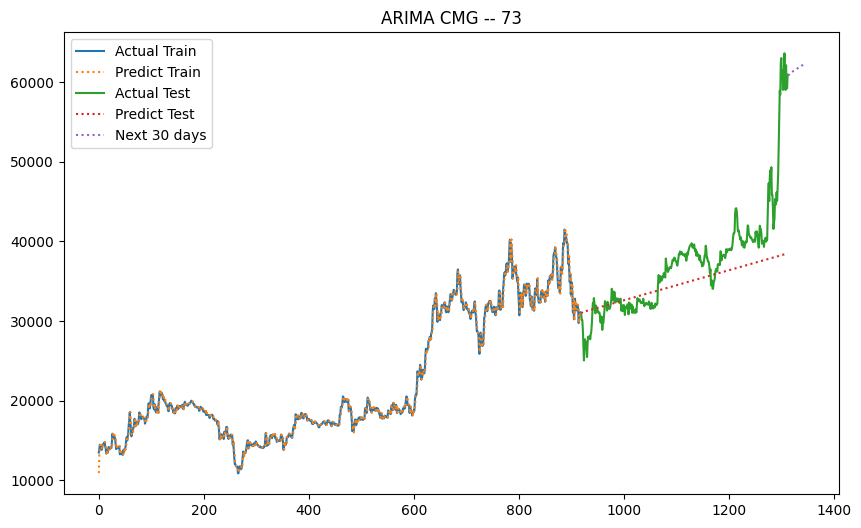

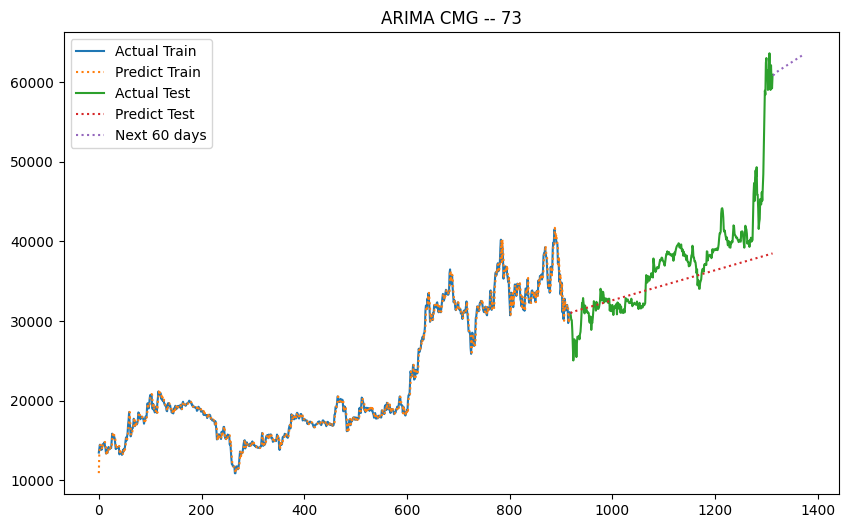

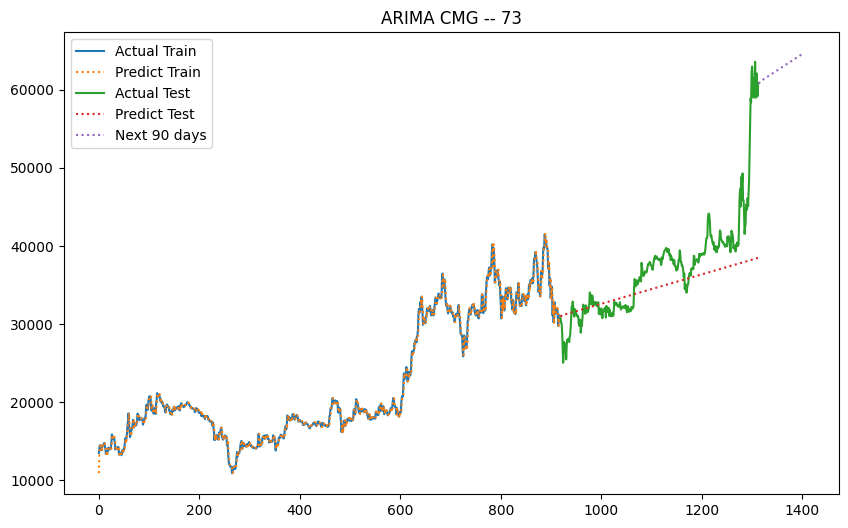

In [24]:
draw_plot(pred_future_30, 30)
draw_plot(pred_future_60, 60)
draw_plot(pred_future_90, 90)